In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


In [13]:
# Define transformation: convert images to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Load MNIST testing dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [14]:
# Define the Encoder network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)

        h = torch.relu(self.fc1(x))

        # Compute mean and log-variance
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        return mu, logvar

In [15]:
# Reparameterization trick
def reparameterize(mu, logvar):
    # Convert log variance to standard deviation
    std = torch.exp(0.5 * logvar)

    # Sample random noise
    eps = torch.randn_like(std)

    # Generate latent vector
    z = mu + eps * std
    return z

In [16]:
# Define the Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28 * 28)

    def forward(self, z):
        h = torch.relu(self.fc1(z))

        # Output values between 0 and 1
        x_recon = torch.sigmoid(self.fc2(h))

        return x_recon

In [17]:
# Define the full VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        # Encode the input
        mu, logvar = self.encoder(x)

        # Sample latent vector
        z = reparameterize(mu, logvar)

        # Decode the latent vector
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

In [18]:
# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x,
        x.view(x.size(0), -1),
        reduction='sum'
    )

    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # Total loss
    total_loss = recon_loss + kl_loss
    return total_loss

In [19]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define latent dimension
latent_dim = 20

# Initialize model
model = VAE(latent_dim).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# Training parameters
epochs = 30

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)

        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 164.2989
Epoch [2/30], Loss: 121.3594
Epoch [3/30], Loss: 114.5428
Epoch [4/30], Loss: 111.5628
Epoch [5/30], Loss: 109.7731
Epoch [6/30], Loss: 108.6286
Epoch [7/30], Loss: 107.7886
Epoch [8/30], Loss: 107.0892
Epoch [9/30], Loss: 106.5825
Epoch [10/30], Loss: 106.1594
Epoch [11/30], Loss: 105.7773
Epoch [12/30], Loss: 105.4252
Epoch [13/30], Loss: 105.1589
Epoch [14/30], Loss: 104.9431
Epoch [15/30], Loss: 104.7254
Epoch [16/30], Loss: 104.4894
Epoch [17/30], Loss: 104.3292
Epoch [18/30], Loss: 104.1781
Epoch [19/30], Loss: 103.9810
Epoch [20/30], Loss: 103.8574
Epoch [21/30], Loss: 103.6900
Epoch [22/30], Loss: 103.5873
Epoch [23/30], Loss: 103.4550
Epoch [24/30], Loss: 103.3225
Epoch [25/30], Loss: 103.2087
Epoch [26/30], Loss: 103.0885
Epoch [27/30], Loss: 103.0299
Epoch [28/30], Loss: 102.9061
Epoch [29/30], Loss: 102.8348
Epoch [30/30], Loss: 102.7612


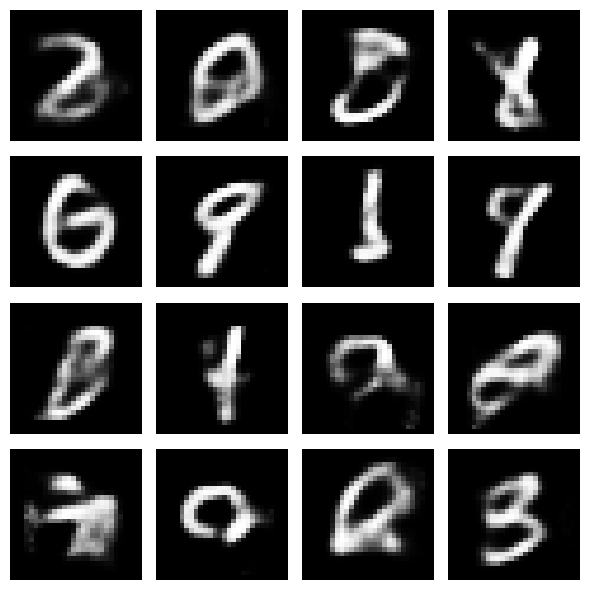

In [10]:
# Set model to evaluation mode
model.eval()

# Number of samples to generate
num_samples = 16

with torch.no_grad():
    # Sample random latent vectors
    z = torch.randn(num_samples, latent_dim).to(device)

    # Generate images using the decoder
    generated_images = model.decoder(z)

    # Reshape for visualization
    generated_images = generated_images.view(num_samples, 28, 28).cpu()

# Plot generated images
plt.figure(figsize=(6, 6))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

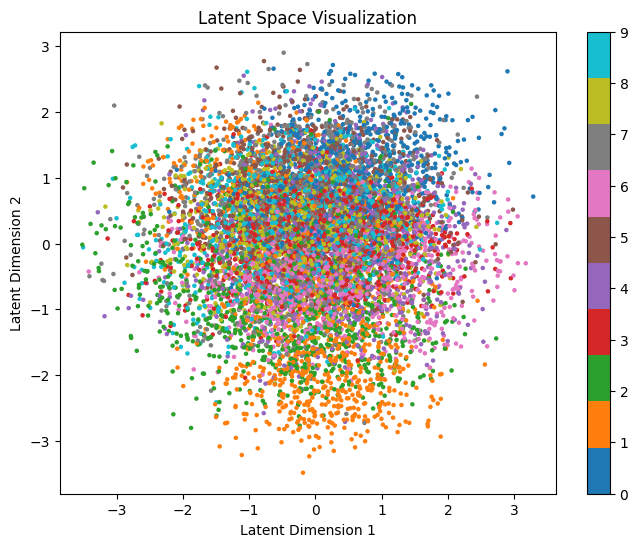

In [11]:
# This visualization works only if latent_dim = 2

model.eval()

latent_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        mu, logvar = model.encoder(images)
        z = reparameterize(mu, logvar)

        latent_vectors.append(z.cpu().numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors)
labels_list = np.concatenate(labels_list)

# Plot latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
            c=labels_list, cmap='tab10', s=5)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()